In [0]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest ,mutual_info_classif, mutual_info_regression, f_classif, chi2
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import set_random_seed
from keras.utils import np_utils , to_categorical

In [0]:
#data = pd.read_csv("/media/mydata/DataScience/05_Extra_Nb/data/train_values.csv")
#data.head()

In [5]:
!pip install -U -q PyDrive
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1O4NqAtFrUgU27IwAlkPg5KFX0KWIzelB'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
downloaded.GetContentFile('train_values.csv')  
data = pd.read_csv('train_values.csv')

In [0]:
#pd.DataFrame(data.groupby(["preapproval","accepted"])["accepted"].count())

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366601 entries, 0 to 499999
Data columns (total 22 columns):
loan_type                         366601 non-null int64
property_type                     366601 non-null int64
loan_purpose                      366601 non-null int64
occupancy                         366601 non-null int64
loan_amount                       366601 non-null int64
preapproval                       366601 non-null int64
msa_md                            366601 non-null float64
state_code                        366601 non-null float64
county_code                       366601 non-null float64
applicant_ethnicity               366601 non-null int64
applicant_race                    366601 non-null int64
applicant_sex                     366601 non-null int64
applicant_income                  366601 non-null float64
population                        366601 non-null float64
minority_population_pct           366601 non-null float64
ffiecmedian_family_income         366

In [156]:
data.describe()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner_occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
count,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.00000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000,366601.000000
mean,1.327620,1.028268,2.067782,1.085488,197.296183,2.806444,214.840729,24.748449,150.287702,2.000276,4.743825,1.439543,85.279334,5541.247992,33.41653,70854.446202,91.520102,1449.287640,1872.366308,3771.338673,0.395026,0.523291
std,0.652392,0.165737,0.944185,0.281037,152.229029,0.461767,124.121875,15.600215,97.733369,0.476115,1.018915,0.623123,50.283214,2817.963446,26.64447,14396.860225,14.564674,763.363731,927.506754,1844.341041,0.488857,0.499458
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,74.000000,0.66100,17858.000000,6.234000,4.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,97.000000,3.000000,101.000000,9.000000,65.000000,2.000000,5.000000,1.000000,48.000000,3822.000000,12.04200,61666.000000,87.315000,947.000000,1283.000000,2458.000000,0.000000,0.000000
50%,1.000000,1.000000,2.000000,1.000000,166.000000,3.000000,223.000000,26.000000,133.000000,2.000000,5.000000,1.000000,74.000000,5077.000000,24.95000,69439.000000,100.000000,1342.000000,1732.000000,3794.000000,0.000000,1.000000
75%,1.000000,1.000000,3.000000,1.000000,264.000000,3.000000,324.000000,37.000000,248.000000,2.000000,5.000000,2.000000,112.000000,6579.000000,48.73200,76627.000000,100.000000,1809.000000,2288.000000,5524.000000,1.000000,1.000000
max,4.000000,2.000000,3.000000,3.000000,15983.000000,3.000000,408.000000,52.000000,323.000000,4.000000,7.000000,4.000000,250.000000,37097.000000,100.00000,125248.000000,100.000000,8771.000000,13623.000000,6507.000000,1.000000,1.000000


In [0]:
data = data.rename(columns = {'number_of_owner-occupied_units':'number_of_owner_occupied_units'})
data["co_applicant"]=(data['co_applicant']).astype(int)
# mark zero values as missing or NaN
data[data.columns] = data[data.columns].replace(-1, np.NaN)
data[data.columns] = data[data.columns].replace("", np.NaN)
# drop rows with missing values
data.dropna(inplace=True)
data = data.drop("row_id",1)

In [8]:
data.shape

(387163, 22)

In [0]:
#drop rows with high income 
values = data["applicant_income"]
remove = values[values > 250 ].values

In [0]:
data["applicant_income"] = data["applicant_income"].replace(to_replace= remove, value=np.NaN)
data["applicant_income"]
data.dropna(inplace=True)

In [0]:
#data.to_csv("clean_data.csv")

In [11]:
data.shape

(366601, 22)

In [12]:
data_num1 = data[["loan_amount", "applicant_income", "population", "minority_population_pct","ffiecmedian_family_income", "tract_to_msa_md_income_pct","number_of_owner_occupied_units","number_of_1_to_4_family_units","accepted"]]
data_num1.head()

,loan_amount,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner_occupied_units,number_of_1_to_4_family_units,accepted
0,70,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,1
1,178,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,0
2,163,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,1
3,155,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,1
4,305,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,1


In [13]:
data_cat = data.drop(data_num1.columns,1)
data_cat["accepted"] = data["accepted"]
data_cat.head()

,loan_type,property_type,loan_purpose,occupancy,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,lender,co_applicant,accepted
0,3,1,1,1,3,18.0,37.0,246.0,2,5,1,4536,0,1
1,1,1,3,1,3,369.0,52.0,299.0,1,5,1,2458,0,0
2,2,1,3,1,3,16.0,10.0,306.0,2,5,1,5710,0,1
3,1,1,1,1,1,305.0,47.0,180.0,2,5,1,5888,1,1
4,1,1,1,1,3,24.0,37.0,20.0,2,3,2,289,0,1


In [0]:
#print the counts for categorical columns 
for col in data_cat.columns:
    print('\nColumn Name:', col,)
    print(data_cat[col].value_counts())

In [0]:
data_num2 = data_num1.drop("accepted", axis=1)
data_num = (data_num2 - data_num2.mean()) / (data_num2.max() - data_num2.min())

In [15]:
data_num["accepted"] = data_num1["accepted"]
data_num

,loan_amount,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner_occupied_units,number_of_1_to_4_family_units,accepted
0,-0.007965,-0.246102,0.017874,0.108854,-0.095600,-0.432855,-0.083642,0.056499,1
1,-0.001207,-0.113572,0.006287,-0.176281,-0.149301,0.090437,0.019700,0.017298,0
2,-0.002146,-0.073411,0.014930,0.280388,-0.029197,0.090437,-0.078623,-0.060517,1
3,-0.002646,0.079199,0.030407,-0.273513,0.070626,0.090437,0.065668,0.031319,1
4,0.006739,-0.057347,0.032162,0.670265,-0.072441,-0.099397,0.001678,-0.001862,1
...,...,...,...,...,...,...,...,...,...
499992,0.007052,0.211730,-0.018455,-0.233750,0.027624,0.090437,0.007039,-0.005092,1
499993,0.000169,0.167553,0.107872,-0.280177,-0.053221,0.090437,0.166957,0.103996,0
499996,-0.003585,0.524983,-0.056431,-0.267061,0.143892,0.090437,-0.002998,0.005259,0
499998,-0.010155,-0.177829,-0.056701,0.658981,-0.098030,-0.306263,-0.094820,-0.042238,0


In [16]:
corr = data_num.corr()
corr.style.background_gradient(cmap='coolwarm')

,loan_amount,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner_occupied_units,number_of_1_to_4_family_units,accepted
loan_amount,1,0.525129,0.018175,-0.00256084,0.299727,0.194565,0.00320304,-0.0549395,0.114547
applicant_income,0.525129,1,0.0290233,-0.0978974,0.21937,0.211246,0.0482036,-0.0157141,0.15469
population,0.018175,0.0290233,1,0.0602903,-0.0534746,0.162192,0.862679,0.851133,0.0179476
minority_population_pct,-0.00256084,-0.0978974,0.0602903,1,-0.0419318,-0.447405,-0.237305,-0.156789,-0.110269
ffiecmedian_family_income,0.299727,0.21937,-0.0534746,-0.0419318,1,-0.0477615,-0.0431276,-0.137368,0.0543474
tract_to_msa_md_income_pct,0.194565,0.211246,0.162192,-0.447405,-0.0477615,1,0.370191,0.215134,0.102119
number_of_owner_occupied_units,0.00320304,0.0482036,0.862679,-0.237305,-0.0431276,0.370191,1,0.910196,0.0403975
number_of_1_to_4_family_units,-0.0549395,-0.0157141,0.851133,-0.156789,-0.137368,0.215134,0.910196,1,0.0118397
accepted,0.114547,0.15469,0.0179476,-0.110269,0.0543474,0.102119,0.0403975,0.0118397,1


In [0]:

def select_kbest_clf(data_frame, target, method ,k):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(method, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

In [18]:

select_kbest_clf(data_num, "accepted" ,method=f_classif, k=4 )

,F Score,P Value,Support,Attribute
0,4874.111506,0.000000e+00,True,loan_amount
1,8987.410524,0.000000e+00,True,applicant_income
2,118.126041,1.642945e-27,False,population
3,4512.452103,0.000000e+00,True,minority_population_pct
4,1086.007237,8.117142e-238,False,ffiecmedian_family_income
5,3863.295529,0.000000e+00,True,tract_to_msa_md_income_pct
6,599.251482,3.113149e-132,False,number_of_owner_occupied_units
7,51.396611,7.561002e-13,False,number_of_1_to_4_family_units


In [19]:
select_kbest_clf(data_cat, "accepted" ,method=chi2, k=10)

,F Score,P Value,Support,Attribute
0,52.912577,3.487295e-13,False,loan_type
1,90.538595,1.814036e-21,True,property_type
2,6968.260471,0.000000e+00,True,loan_purpose
3,14.552915,1.362777e-04,False,occupancy
4,468.998048,5.294211e-104,True,preapproval
5,358.031546,7.554614e-80,True,msa_md
6,3902.355519,0.000000e+00,True,state_code
7,425.486756,1.560296e-94,True,county_code
8,3.181273,7.448668e-02,False,applicant_ethnicity
9,99.235596,2.241812e-23,True,applicant_race


In [20]:
select_kbest_clf(data_cat, "accepted" ,method=mutual_info_classif, k=7)

,F Score,P Value,Support,Attribute
0,0.022378,None,False,loan_type
1,0.047907,None,True,property_type
2,0.049744,None,True,loan_purpose
3,0.035401,None,True,occupancy
4,0.038346,None,True,preapproval
5,0.007073,None,False,msa_md
6,0.008276,None,False,state_code
7,0.002089,None,False,county_code
8,0.031821,None,True,applicant_ethnicity
9,0.035991,None,True,applicant_race


Grid search

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [0]:
#RandomForestClassifier?

In [0]:
rfc=RandomForestClassifier(random_state=42)

In [0]:
gsc = RandomizedSearchCV(
        estimator=rfc,
        param_distributions={
            'n_estimators': [100,200,300],
            'max_features': ["auto","sqrt","log2"],
            'max_depth': [4,5,6,7,8],
            'criterion':["gini","entropy"]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_iter=5)

In [0]:
feature_col =['loan_type','property_type','loan_purpose','occupancy', 'preapproval',
              'applicant_race','loan_amount','applicant_income',
              'minority_population_pct','tract_to_msa_md_income_pct']
X = data[feature_col] #Features
y = data['accepted'] #target

In [0]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [0]:
grid_result = gsc.fit(X_train, y_train)

In [0]:
best_params = grid_result.best_params_

In [38]:
best_params

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 300}

In [41]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators=300, max_depth=7, max_features='auto', criterion='gini')
#10-fold cross validation
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print("Accuracy",scores.mean())

Accuracy 0.657150450949989


ANN


In [0]:
# define the model
def baseline():
    model = Sequential()
    model.add(Dense(25, input_dim=10, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
model = baseline()

In [146]:
X_train = np.array(X_train)
y_train = to_categorical(np.array(y_train))
history = model.fit(X_train, y_train,epochs = 10)
model.summary()

Epoch 1/10
256620/256620 [==============================] - 57s 221us/step - loss: 0.6512 - acc: 0.6212
Epoch 2/10
256620/256620 [==============================] - 54s 211us/step - loss: 0.6346 - acc: 0.6418
Epoch 3/10
256620/256620 [==============================] - 53s 208us/step - loss: 0.6325 - acc: 0.6438
Epoch 4/10
256620/256620 [==============================] - 53s 208us/step - loss: 0.6310 - acc: 0.6443
Epoch 5/10
256620/256620 [==============================] - 54s 210us/step - loss: 0.6296 - acc: 0.6461
Epoch 6/10
256620/256620 [==============================] - 53s 205us/step - loss: 0.6288 - acc: 0.6463
Epoch 7/10
256620/256620 [==============================] - 53s 206us/step - loss: 0.6278 - acc: 0.6474
Epoch 8/10
256620/256620 [==============================] - 52s 203us/step - loss: 0.6273 - acc: 0.6479
Epoch 9/10
256620/256620 [==============================] - 52s 204us/step - loss: 0.6266 - acc: 0.6487
Epoch 10/10
256620/256620 [==============================] - 52s

In [0]:
prediction = model.predict(X_test)
prediction_classes = model.predict_classes(X_test)

In [148]:
confusion_matrix(np.array(y_test), prediction_classes)

array([[33803, 18488],
       [19814, 37876]])

In [149]:
accuracy_score(np.array(y_test), prediction_classes)

0.6517398459733954

In [0]:
def plot_hist(h, xsize=6, ysize=10):

    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
    
    # summarize history for Accuracy
    plt.subplot(211)
    plt.plot(h['acc'])
    plt.plot(h['loss'])
    plt.title('Training Performance')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Accuracy', 'Loss'], loc='best')    
    plt.draw()
    plt.show()

    return

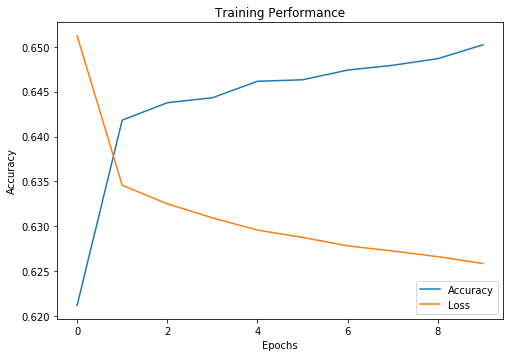

In [153]:
plot_hist(history.history, xsize=8, ysize=12)

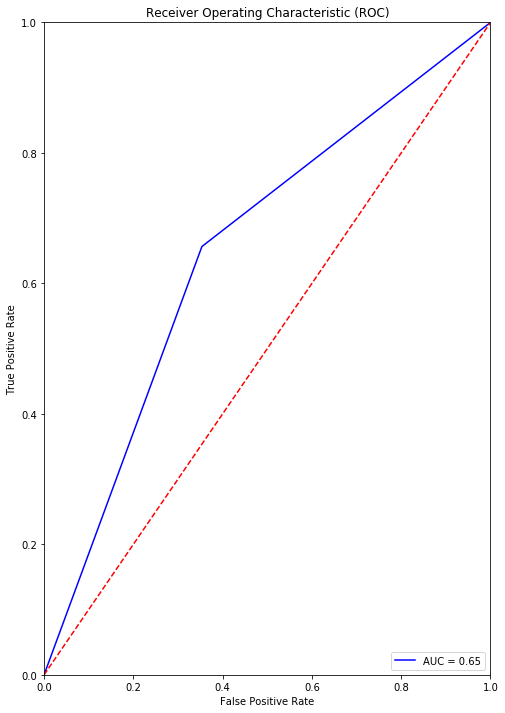

In [154]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, prediction_classes)
roc_auc = sklearn.metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
